In [15]:
import stockinator as st
import yfinance as yf
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt
from matplotlib.pylab import date2num
from mplfinance.original_flavor import candlestick_ohlc
import requests
import datetime
import time
import os
import sys
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)

In [2]:
all_data = pd.read_pickle('stocks/all_1d.pkl')
stocklist = st.unique_list([x[0] for x in all_data.columns.values])
total_stocks = len(stocklist)

In [37]:
def plot_chart(data, n, ticker):
    
    # Filter number of observations to plot
    data = data.iloc[-n:]
    
    # Create figure and set axes for subplots
    fig = plt.figure()
    fig.set_size_inches((24, 8))
    ax_candle = fig.add_axes((0, 0.72, 1, 0.8))
    #ax_macd = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
    ax_rsi = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
    ax_vol = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    
    # Format x-axis ticks as dates
    ax_candle.xaxis_date()
    
    # Get nested list of date, open, high, low and close prices
    ohlc = []
    for date, row in data.iterrows():
        openp, highp, lowp, closep = row[:4]
        ohlc.append([date2num(date), openp, highp, lowp, closep])
 
    # Plot candlestick chart
    ax_candle.plot(data.index, data["EMA 20"], label="EMA 20")
    ax_candle.plot(data.index, data["EMA 50"], label="EMA 50")
    ax_candle.plot(data.index, data["EMA 100"], label="EMA 100")
    ax_candle.plot(data.index, data["EMA 150"], label="EMA 150")
    ax_candle.plot(data.index, data["EMA 200"], label="EMA 200")
    candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=1.2)
    ax_candle.set_title(ticker)
    ax_candle.legend()
    
    # Plot MACD
    #ax_macd.plot(data.index, data["macd"], label="macd")
    #ax_macd.bar(data.index, data["macd_hist"] * 3, label="hist")
    #ax_macd.plot(data.index, data["macd_signal"], label="signal")
    #ax_macd.legend()
    
    # Plot RSI
    # Above 70% = overbought, below 30% = oversold
    ax_rsi.set_ylabel("(%)")
    ax_rsi.plot(data.index, [70] * len(data.index), label="overbought")
    ax_rsi.plot(data.index, [30] * len(data.index), label="oversold")
    ax_rsi.plot(data.index, data["RSI"], label="RSI")
    ax_rsi.legend()
    
    # Show volume in millions
    ax_vol.bar(data.index, data["Volume"] / 1000000)
    ax_vol.set_ylabel("(Million)")
   
    # Save the chart as PNG
    fig.savefig("charts/" + ticker + ".png", bbox_inches="tight")
    
    plt.show()

In [3]:
class TickerData:
    columns = [
        'Stock', 'Price', 
        '90 Avg Volume', '10 Avg Volume', 
        'EMA 20', 'EMA 50', 'EMA 100', 'EMA 150', 'EMA 200',
        '52 Week Low', '52 Week High', 'Pct of 52 High',
        'RSI', 'MFI'
    ]
    
    def __init__(self, ticker, df):
        self.ticker = ticker
        self.df = df

In [40]:
columns = [
    'Stock', 'Price', 
    '90 Avg Volume', '10 Avg Volume', 
    'EMA 20', 'EMA 50', 'EMA 100', 'EMA 150', 'EMA 200',
    '52 Week Low', '52 Week High', 'Pct of 52 High',
    'RSI', 'MFI'
]

bounce = {
    '20': [],
    '50':[],
    '100': [],
    '150': [],
    '200': []
}

offset = 0
n = -1
for stock in stocklist:
    n += 1
    #print("Index {} of {} Stock [{}] \r".format(n, total_stocks, stock))
    sys.stdout.write("Index {} of {} Stock [{}] \r".format(n, total_stocks-1, stock))
    sys.stdout.flush()

    df = all_data[stock]
    if offset > 0:
        df = df[:-offset]

    df = df.dropna(how='all')
    if df.empty:
        continue

    df = st.calculate_rsi(df)
    df = st.calculate_ma(df, type='ema', periods=[20, 50, 100, 150, 200])
    df = st.calculate_volume(df)
    df = st.calculate_mfi(df)

    try:
        moving_average_long_21 = df["EMA 200"][-21]
    except Exception:
        moving_average_long_21 = 0

    try:
        currentOpen = df["Open"][-1]
        currentClose = df["Adj Close"][-1]
        low_of_52week = min(df["Adj Close"][-260:])
        high_of_52week = max(df["Adj Close"][-260:])
        ma_20 = df["EMA 20"][-1]
        ma_50 = df["EMA 50"][-1]
        ma_100 = df["EMA 100"][-1]
        ma_150 = df["EMA 150"][-1]
        ma_200 = df["EMA 200"][-1]
        avg_volume_90 = df['90 Avg Volume'][-1]
        avg_volume_10 = df['10 Avg Volume'][-1]
        rsi = df['RSI'][-1]
    except Exception:
        continue

    try:
        assert(currentClose > 5)
        assert(avg_volume_90 > 250000)
        #assert(currentClose > moving_average_short > moving_average_medium > moving_average_long)
        assert(ma_20 > ma_200)
        assert(currentClose > currentOpen)
        if currentClose <= ma_20 * 1.01 and currentClose >= ma_20 * .99:
            bounce['20'].append(TickerData(stock, df))
            continue
            
        if currentClose <= ma_50 * 1.01 and currentClose >= ma_50 * .99:
            bounce['50'].append(TickerData(stock, df))
            continue
            
        if currentClose <= ma_100 * 1.01 and currentClose >= ma_100 * .99:
            bounce['100'].append(TickerData(stock, df))
            continue
            
        if currentClose <= ma_150 * 1.01 and currentClose >= ma_150 * .99:
            bounce['150'].append(TickerData(stock, df))
            continue
            
        if currentClose <= ma_200 * 1.01 and currentClose >= ma_200 * .99:
            bounce['200'].append(TickerData(stock, df))
            continue
        #assert(currentClose <= ma_50 * 1.05)
        #assert(currentClose >= ma_50 * .95)
        
        #assert(currentClose >= (1.3 * low_of_52week))
        #assert(currentClose >= (.80 * high_of_52week))
        #assert(rsi > 40)
        #assert(rsi < 60)
        #assert(avg_volume_10 > avg_volume_90)
    except AssertionError:
        continue
    except IndexError as e:
        continue
    except Exception as e:
        print(e)

    #try:
    #    exportList = exportList.append(
    #        {
    #            'Stock': stock, 
    #            'RSI': rsi, 
    #            'Price': currentClose,
    #            '90 Avg Volume': avg_volume_90,
    #            '10 Avg Volume': avg_volume_10,
    #            'SMA_50': ma_50, 
    #            'SMA_150': ma_150, 
    #            'SMA_200': ma_200, 
    #            '52 Week Low': low_of_52week, 
    #            '52 Week High': high_of_52week,
    #            'Pct of 52 High': (currentClose / high_of_52week) * 100
    #        }, ignore_index=True)
    #except Exception as e:
    #    print(e)

In [44]:
print(len(bounce['20']))
print(len(bounce['50']))
print(len(bounce['100']))
print(len(bounce['150']))
print(len(bounce['200']))

56
12
4
2
2


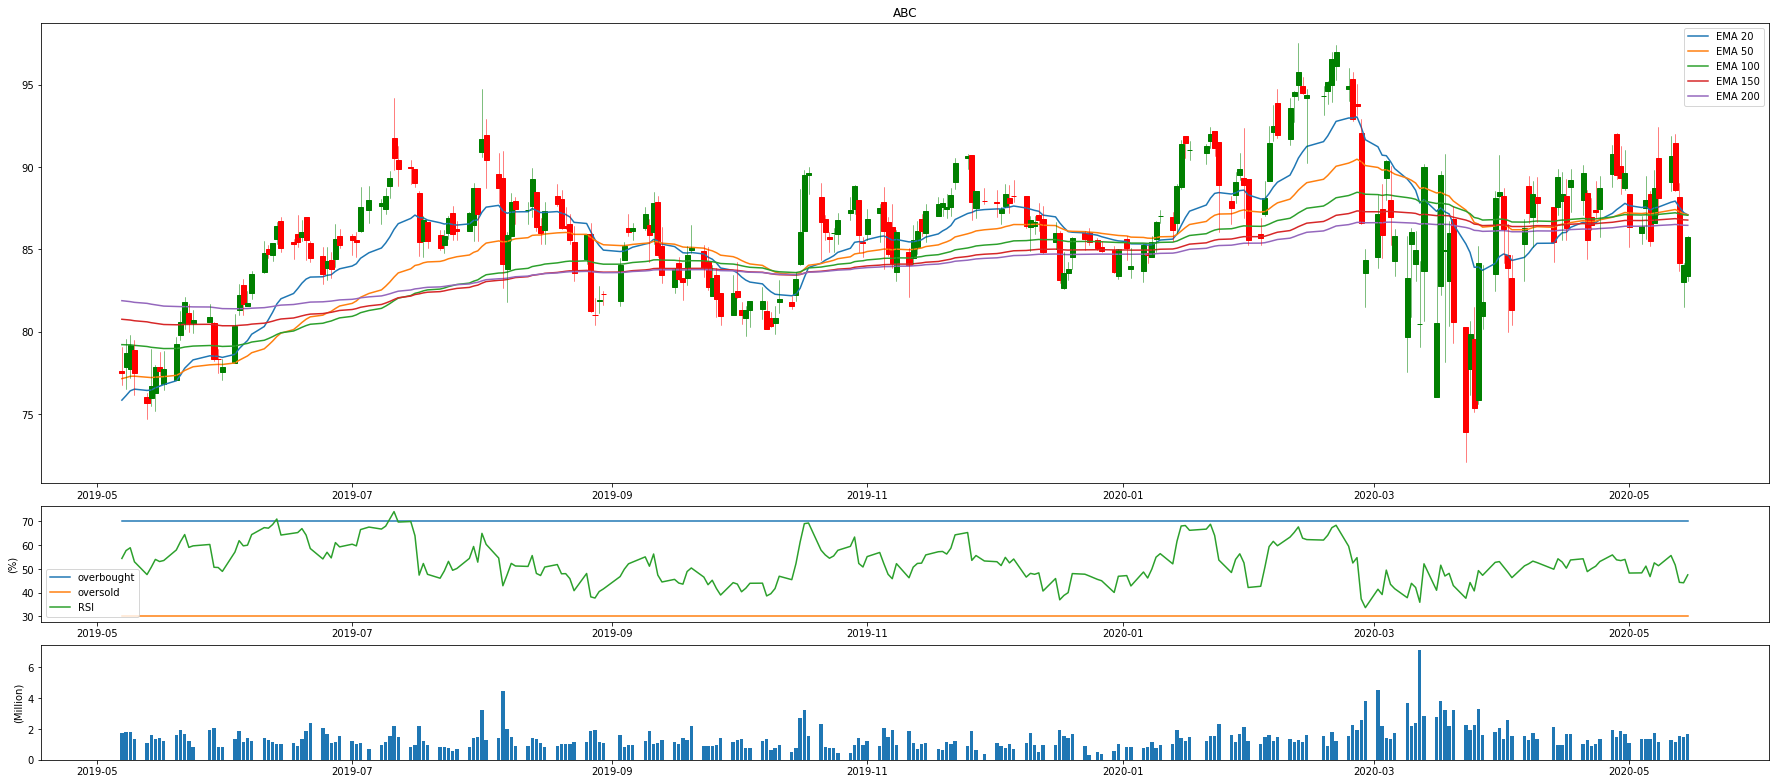

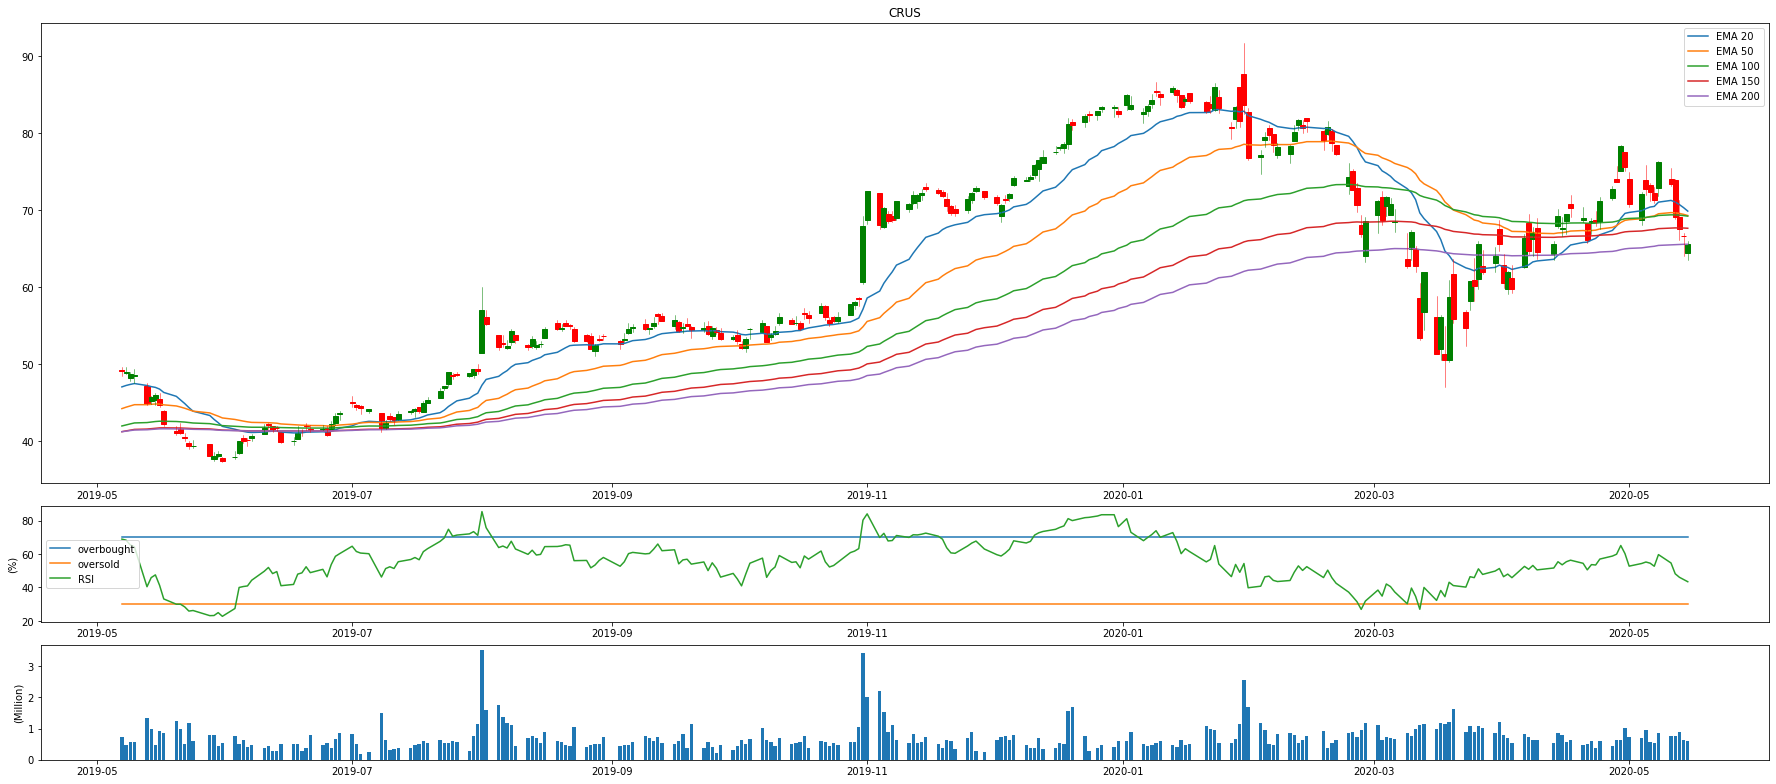

In [47]:
for s in bounce['200']:
    plot_chart(s.df, 260, s.ticker)
    #df = s.df[-260:]
    #plt.figure(figsize=(15,5))
    #plt.xlabel("Date")
    #plt.ylabel("Price")
    #plt.title(s.ticker)
    #plt.plot(df.index, df['Adj Close'], label=s.ticker)
    #plt.plot(df.index, df['EMA 20'], label='EMA 20') 
    #plt.plot(df.index, df['EMA 50'], label='EMA 50') 
    #plt.plot(df.index, df['EMA 100'], label='EMA 100') 
    #plt.plot(df.index, df['EMA 150'], label='EMA 150') 
    #plt.plot(df.index, df['EMA 200'], label='EMA 200') 
    #plt.legend()
    #plt.show()

    # Save the chart as PNG
    #fig.savefig("charts/" + ticker + ".png", bbox_inches="tight")